In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

sns.set()

In [82]:
from sklearn.metrics import r2_score
import xgboost as xgb
import pickle
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import os
import shutil

In [83]:
df = pd.read_excel("Data_Train.xlsx")

### We have a Regression Problem since we will predict Price (continuous feature)

In [84]:
pd.set_option('display.max_columns', None)
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


## Exploratory Data Analysis

In [85]:
df.shape

(10683, 11)

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


### Exploring each feature

In [87]:
for col in df.columns:
    print(col + " : " + str(df[col].unique()))

Airline : ['IndiGo' 'Air India' 'Jet Airways' 'SpiceJet' 'Multiple carriers' 'GoAir'
 'Vistara' 'Air Asia' 'Vistara Premium economy' 'Jet Airways Business'
 'Multiple carriers Premium economy' 'Trujet']
Date_of_Journey : ['24/03/2019' '1/05/2019' '9/06/2019' '12/05/2019' '01/03/2019'
 '24/06/2019' '12/03/2019' '27/05/2019' '1/06/2019' '18/04/2019'
 '9/05/2019' '24/04/2019' '3/03/2019' '15/04/2019' '12/06/2019'
 '6/03/2019' '21/03/2019' '3/04/2019' '6/05/2019' '15/05/2019'
 '18/06/2019' '15/06/2019' '6/04/2019' '18/05/2019' '27/06/2019'
 '21/05/2019' '06/03/2019' '3/06/2019' '15/03/2019' '3/05/2019'
 '9/03/2019' '6/06/2019' '24/05/2019' '09/03/2019' '1/04/2019'
 '21/04/2019' '21/06/2019' '27/03/2019' '18/03/2019' '12/04/2019'
 '9/04/2019' '1/03/2019' '03/03/2019' '27/04/2019']
Source : ['Banglore' 'Kolkata' 'Delhi' 'Chennai' 'Mumbai']
Destination : ['New Delhi' 'Banglore' 'Cochin' 'Kolkata' 'Delhi' 'Hyderabad']
Route : ['BLR → DEL' 'CCU → IXR → BBI → BLR' 'DEL → LKO → BOM → COK'
 'CCU →

### Missing values

In [88]:
df.isna().sum()

# There are only 2 missing values. Those values are missing completely randomly.

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [89]:
# All features are categorical
categorical_features=[feature for feature in df.columns if df[feature].dtypes=='O' and feature not in ["Price"]]
categorical_features

['Airline',
 'Date_of_Journey',
 'Source',
 'Destination',
 'Route',
 'Dep_Time',
 'Arrival_Time',
 'Duration',
 'Total_Stops',
 'Additional_Info']

In [90]:
for feature in categorical_features:
    print('The feature is {} and number of categories are {}'.format(feature,len(df[feature].unique())))
    
# Some features have few categories, some of them have high nr of unique categories

The feature is Airline and number of categories are 12
The feature is Date_of_Journey and number of categories are 44
The feature is Source and number of categories are 5
The feature is Destination and number of categories are 6
The feature is Route and number of categories are 129
The feature is Dep_Time and number of categories are 222
The feature is Arrival_Time and number of categories are 1343
The feature is Duration and number of categories are 368
The feature is Total_Stops and number of categories are 6
The feature is Additional_Info and number of categories are 10


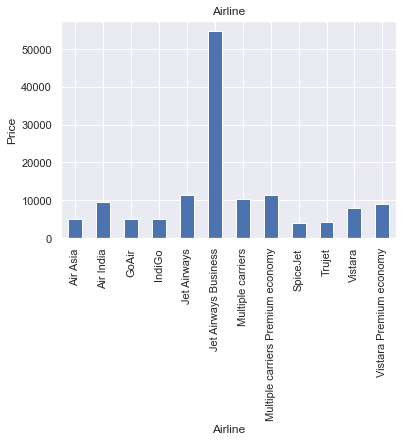

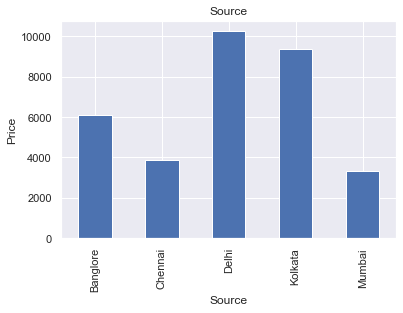

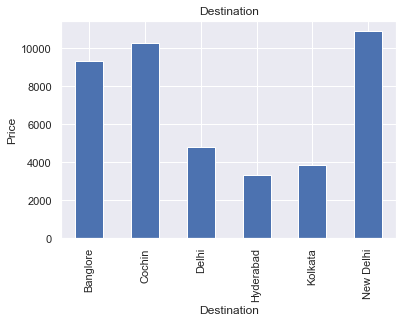

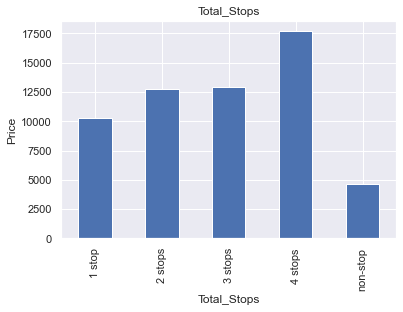

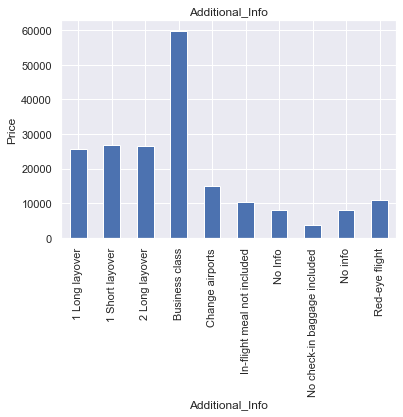

In [91]:
## Find out the relationship between categorical variable (with few categories) and dependent feature Price

new_features = [feature for feature in categorical_features if feature not in ["Route", "Dep_Time", "Arrival_Time", 
                                                                               "Duration", "Date_of_Journey"]]
for feature in new_features :
    data=df.copy()
    data.groupby(feature)['Price'].median().plot.bar()
    plt.xlabel(feature)
    plt.ylabel('Price')
    plt.title(feature)
    plt.show()

## Feature Engineering

### Handling missing values

In [92]:
# Since we have only 2 missing values we can drop the rows which contain these missing values (we are not losing too much info)
df.dropna(inplace=True)

In [93]:
df.isna().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

### Encoding categorical features

In [94]:
df["Date_of_Journey"].value_counts()

18/05/2019    504
6/06/2019     503
21/05/2019    497
9/06/2019     495
12/06/2019    493
9/05/2019     484
21/03/2019    423
15/05/2019    405
27/05/2019    382
27/06/2019    355
24/06/2019    351
1/06/2019     342
3/06/2019     333
15/06/2019    328
24/03/2019    323
6/03/2019     308
27/03/2019    299
24/05/2019    286
6/05/2019     281
1/05/2019     277
12/05/2019    259
1/04/2019     257
3/03/2019     218
9/03/2019     200
15/03/2019    162
18/03/2019    156
01/03/2019    152
12/03/2019    142
9/04/2019     125
3/04/2019     110
21/06/2019    109
18/06/2019    105
09/03/2019    102
6/04/2019     100
03/03/2019     97
06/03/2019     95
27/04/2019     94
24/04/2019     92
3/05/2019      90
15/04/2019     89
21/04/2019     82
18/04/2019     67
12/04/2019     63
1/03/2019      47
Name: Date_of_Journey, dtype: int64

In [95]:
df["Journey_day"] = pd.to_datetime(df.Date_of_Journey, format="%d/%m/%Y").dt.day
df["Journey_month"] = pd.to_datetime(df["Date_of_Journey"], format = "%d/%m/%Y").dt.month
df["Journey_year"] = pd.to_datetime(df["Date_of_Journey"], format = "%d/%m/%Y").dt.year
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Journey_year
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3,2019
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,1,5,2019
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,9,6,2019
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218,12,5,2019
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302,1,3,2019


In [96]:
df["Journey_year"].unique()

array([2019], dtype=int64)

In [97]:
# The year is 2019 for all records so we are going to drop this column
# Date_of_Journey we dont'need anymore.

df.drop(["Journey_year", "Date_of_Journey"], axis=1, inplace=True)
df.head()

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month
0,IndiGo,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,1,5
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,9,6
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218,12,5
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302,1,3


In [98]:
df["Dep_Time"].unique()

array(['22:20', '05:50', '09:25', '18:05', '16:50', '09:00', '18:55',
       '08:00', '08:55', '11:25', '09:45', '20:20', '11:40', '21:10',
       '17:15', '16:40', '08:45', '14:00', '20:15', '16:00', '14:10',
       '22:00', '04:00', '21:25', '21:50', '07:00', '07:05', '09:50',
       '14:35', '10:35', '15:05', '14:15', '06:45', '20:55', '11:10',
       '05:45', '19:00', '23:05', '11:00', '09:35', '21:15', '23:55',
       '19:45', '08:50', '15:40', '06:05', '15:00', '13:55', '05:55',
       '13:20', '05:05', '06:25', '17:30', '08:20', '19:55', '06:30',
       '14:05', '02:00', '09:40', '08:25', '20:25', '13:15', '02:15',
       '16:55', '20:45', '05:15', '19:50', '20:00', '06:10', '19:30',
       '04:45', '12:55', '18:15', '17:20', '15:25', '23:00', '12:00',
       '14:45', '11:50', '11:30', '14:40', '19:10', '06:00', '23:30',
       '07:35', '13:05', '12:30', '15:10', '12:50', '18:25', '16:30',
       '00:40', '06:50', '13:00', '19:15', '01:30', '17:00', '10:00',
       '19:35', '15:

In [99]:
# Departure time is when a plane leaves the gate. 
# Similar to Date_of_Journey we can extract values from Dep_Time

# Extracting Hours
df["Dep_hour"] = pd.to_datetime(df["Dep_Time"]).dt.hour

# Extracting Minutes
df["Dep_min"] = pd.to_datetime(df["Dep_Time"]).dt.minute

# Now we can drop Dep_Time as it is of no use
df.drop(["Dep_Time"], axis = 1, inplace = True)
df.head()

,Airline,Source,Destination,Route,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min
0,IndiGo,Banglore,New Delhi,BLR → DEL,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3,22,20
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,13:15,7h 25m,2 stops,No info,7662,1,5,5,50
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,04:25 10 Jun,19h,2 stops,No info,13882,9,6,9,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,23:30,5h 25m,1 stop,No info,6218,12,5,18,5
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,21:35,4h 45m,1 stop,No info,13302,1,3,16,50


In [100]:
# Arrival time is when the plane pulls up to the gate.
# Similar to Date_of_Journey we can extract values from Arrival_Time

# Extracting Hours
df["Arrival_hour"] = pd.to_datetime(df.Arrival_Time).dt.hour

# Extracting Minutes
df["Arrival_min"] = pd.to_datetime(df.Arrival_Time).dt.minute

# Now we can drop Arrival_Time as it is of no use
df.drop(["Arrival_Time"], axis = 1, inplace = True)
df.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,1,5,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,2 stops,No info,13882,9,6,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,12,5,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,1,3,16,50,21,35


In [101]:
df["Duration"].unique()[:10]

array(['2h 50m', '7h 25m', '19h', '5h 25m', '4h 45m', '2h 25m', '15h 30m',
       '21h 5m', '25h 30m', '7h 50m'], dtype=object)

In [102]:
# Time taken by plane to reach destination is called Duration
# It is the differnce betwwen Departure Time and Arrival time

# Assigning and converting Duration column into list
duration = list(df["Duration"])

for i in range(len(duration)):
    if len(duration[i].split()) != 2:    # Check if duration contains only hour or mins
        if "h" in duration[i]:
            duration[i] = duration[i].strip() + " 0m"   # Adds 0 minute
        else:
            duration[i] = "0h " + duration[i]           # Adds 0 hour

duration_hours = []
duration_mins = []
for i in range(len(duration)):
    duration_hours.append(int(duration[i].split(sep = "h")[0]))    # Extract hours from duration
    duration_mins.append(int(duration[i].split(sep = "m")[0].split()[-1]))   # Extracts only minutes from duration

In [103]:
# Adding duration_hours and duration_mins list to train_data dataframe

df["Duration_hours"] = duration_hours
df["Duration_mins"] = duration_mins
df.drop(["Duration"], axis = 1, inplace = True)
df.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,No info,13302,1,3,16,50,21,35,4,45


### Encoding categorical features

In [104]:
# Airline is nominal feature
df["Airline"].value_counts()

Jet Airways                          3849
IndiGo                               2053
Air India                            1751
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

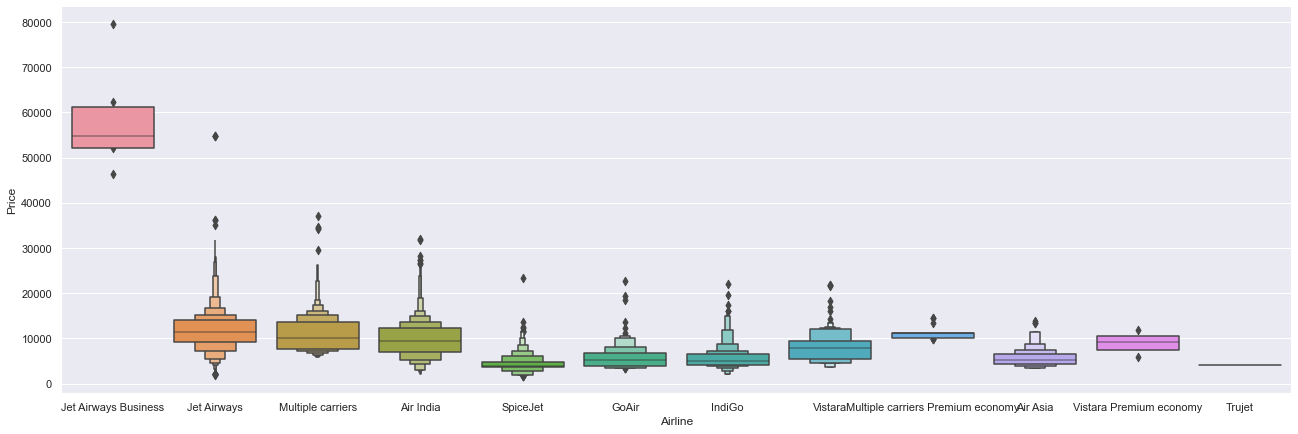

In [105]:
#From graph we can see that Jet Airways Business have the highest Price.

# Airline vs Price
sns.catplot(y = "Price", x = "Airline", data = df.sort_values("Price", ascending = False), kind="boxen", height = 6, aspect = 3)
plt.show()

In [106]:
# As Airline is Nominal Categorical data we will perform OneHotEncoding

Airline = df[["Airline"]]
Airline = pd.get_dummies(Airline, drop_first= True)

Airline.head()

,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy
0,0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0


In [107]:
df["Source"].value_counts()

Delhi       4536
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381
Name: Source, dtype: int64

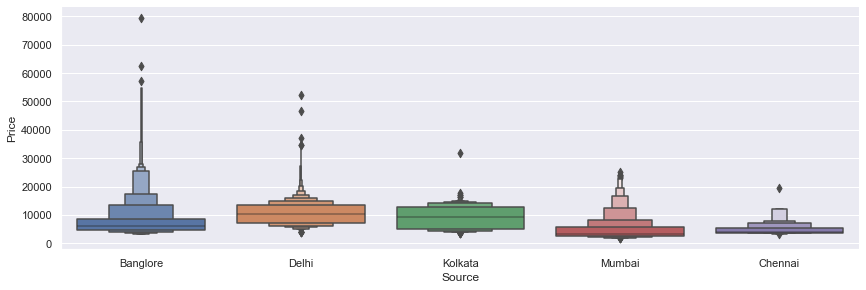

In [108]:
# Source vs Price

sns.catplot(y = "Price", x = "Source", data = df.sort_values("Price", ascending = False), kind="boxen", height = 4, aspect = 3)
plt.show()

In [109]:
# As Source is Nominal Categorical data we will perform OneHotEncoding

Source = df[["Source"]]

Source = pd.get_dummies(Source, drop_first= True)

Source.head()

,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai
0,0,0,0,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,0


In [110]:
df["Destination"].value_counts()

Cochin       4536
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

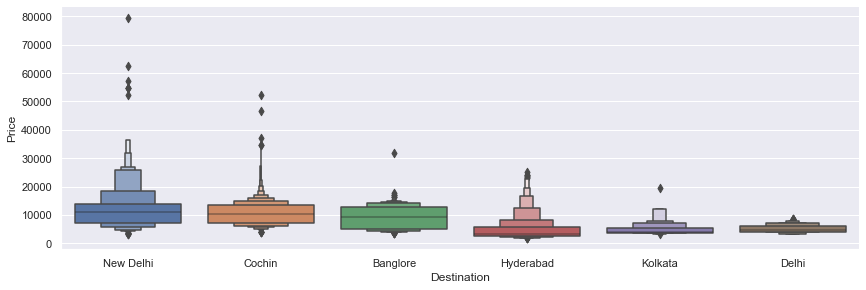

In [111]:
# Destination vs Price

sns.catplot(y = "Price", x = "Destination", data = df.sort_values("Price", ascending = False), kind="boxen", height = 4, aspect = 3)
plt.show()

In [112]:
# As Destination is Nominal Categorical data we will perform OneHotEncoding

Destination = df[["Destination"]]
Destination = pd.get_dummies(Destination, drop_first = True)
Destination.head()

,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,0,0,0,1
1,0,0,0,0,0
2,1,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,1


In [113]:
df["Route"]

0                    BLR → DEL
1        CCU → IXR → BBI → BLR
2        DEL → LKO → BOM → COK
3              CCU → NAG → BLR
4              BLR → NAG → DEL
                 ...          
10678                CCU → BLR
10679                CCU → BLR
10680                BLR → DEL
10681                BLR → DEL
10682    DEL → GOI → BOM → COK
Name: Route, Length: 10682, dtype: object

In [114]:
df["Additional_Info"].value_counts() / len(df)

No info                         0.781127
In-flight meal not included     0.185546
No check-in baggage included    0.029957
1 Long layover                  0.001779
Change airports                 0.000655
Business class                  0.000374
No Info                         0.000281
1 Short layover                 0.000094
Red-eye flight                  0.000094
2 Long layover                  0.000094
Name: Additional_Info, dtype: float64

In [115]:
# Additional_Info contains almost 80% no_info
# Route and Total_Stops are related to each other so i am going to drop route

df.drop(["Route", "Additional_Info"], axis = 1, inplace = True)

In [116]:
df["Total_Stops"].value_counts()

1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64

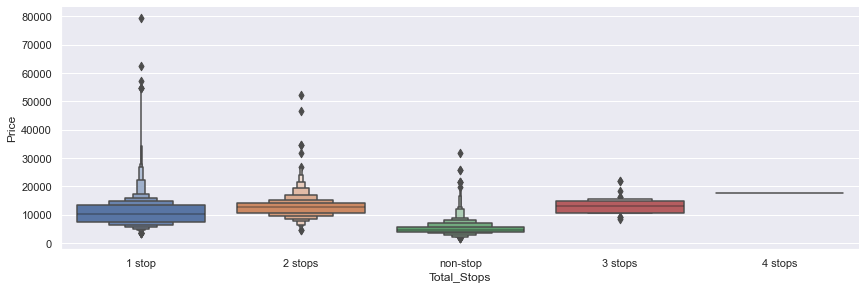

In [117]:
# TOtal_Stops vs Price

sns.catplot(y = "Price", x = "Total_Stops", data = df.sort_values("Price", ascending = False), kind="boxen", height = 4, aspect = 3)
plt.show()

# Higher the total nr of stops, higher the price

In [118]:
# As this is case of Ordinal Categorical type we perform LabelEncoder
# Here Values are assigned with corresponding keys

df.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace = True)

In [119]:
df.head()

,Airline,Source,Destination,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,New Delhi,0,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,1,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,1,13302,1,3,16,50,21,35,4,45


In [120]:
# Concatenate dataframe --> train_data + Airline + Source + Destination

df = pd.concat([df, Airline, Source, Destination], axis = 1)
df.head()

,Airline,Source,Destination,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,IndiGo,Banglore,New Delhi,0,3897,24,3,22,20,1,10,2,50,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,Air India,Kolkata,Banglore,2,7662,1,5,5,50,13,15,7,25,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,Jet Airways,Delhi,Cochin,2,13882,9,6,9,25,4,25,19,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,IndiGo,Kolkata,Banglore,1,6218,12,5,18,5,23,30,5,25,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,IndiGo,Banglore,New Delhi,1,13302,1,3,16,50,21,35,4,45,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [121]:
df.drop(["Airline", "Source", "Destination"], axis = 1, inplace = True)
df.head()

,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,3897,24,3,22,20,1,10,2,50,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2,7662,1,5,5,50,13,15,7,25,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2,13882,9,6,9,25,4,25,19,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,1,6218,12,5,18,5,23,30,5,25,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,1,13302,1,3,16,50,21,35,4,45,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [122]:
df.shape

(10682, 30)

### TEST DATA

In [123]:
test_data = pd.read_excel("Test_set.xlsx")
test_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


Test data does not have the price. <br>
We do all the preprocessing operations that we did on training set again on test set.

In [124]:
# Preprocessing

print("Test data Info")
print("-"*75)
print(test_data.info())

print()
print()

print("Null values :")
print("-"*75)
test_data.dropna(inplace = True)
print(test_data.isnull().sum())

# EDA

# Date_of_Journey
test_data["Journey_day"] = pd.to_datetime(test_data.Date_of_Journey, format="%d/%m/%Y").dt.day
test_data["Journey_month"] = pd.to_datetime(test_data["Date_of_Journey"], format = "%d/%m/%Y").dt.month
test_data.drop(["Date_of_Journey"], axis = 1, inplace = True)

# Dep_Time
test_data["Dep_hour"] = pd.to_datetime(test_data["Dep_Time"]).dt.hour
test_data["Dep_min"] = pd.to_datetime(test_data["Dep_Time"]).dt.minute
test_data.drop(["Dep_Time"], axis = 1, inplace = True)

# Arrival_Time
test_data["Arrival_hour"] = pd.to_datetime(test_data.Arrival_Time).dt.hour
test_data["Arrival_min"] = pd.to_datetime(test_data.Arrival_Time).dt.minute
test_data.drop(["Arrival_Time"], axis = 1, inplace = True)

# Duration
duration = list(test_data["Duration"])

for i in range(len(duration)):
    if len(duration[i].split()) != 2:    # Check if duration contains only hour or mins
        if "h" in duration[i]:
            duration[i] = duration[i].strip() + " 0m"   # Adds 0 minute
        else:
            duration[i] = "0h " + duration[i]           # Adds 0 hour

duration_hours = []
duration_mins = []
for i in range(len(duration)):
    duration_hours.append(int(duration[i].split(sep = "h")[0]))    # Extract hours from duration
    duration_mins.append(int(duration[i].split(sep = "m")[0].split()[-1]))   # Extracts only minutes from duration

# Adding Duration column to test set
test_data["Duration_hours"] = duration_hours
test_data["Duration_mins"] = duration_mins
test_data.drop(["Duration"], axis = 1, inplace = True)

# Categorical data

print("Airline")
print("-"*75)
print(test_data["Airline"].value_counts())
Airline = pd.get_dummies(test_data["Airline"], drop_first= True)

print()

print("Source")
print("-"*75)
print(test_data["Source"].value_counts())
Source = pd.get_dummies(test_data["Source"], drop_first= True)

print()

print("Destination")
print("-"*75)
print(test_data["Destination"].value_counts())
Destination = pd.get_dummies(test_data["Destination"], drop_first = True)

# Additional_Info contains almost 80% no_info
# Route and Total_Stops are related to each other
test_data.drop(["Route", "Additional_Info"], axis = 1, inplace = True)

# Replacing Total_Stops
test_data.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace = True)

# Concatenate dataframe --> test_data + Airline + Source + Destination
data_test = pd.concat([test_data, Airline, Source, Destination], axis = 1)

data_test.drop(["Airline", "Source", "Destination"], axis = 1, inplace = True)

print()
print()

print("Shape of test data : ", data_test.shape)

Test data Info
---------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2671 entries, 0 to 2670
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          2671 non-null   object
 1   Date_of_Journey  2671 non-null   object
 2   Source           2671 non-null   object
 3   Destination      2671 non-null   object
 4   Route            2671 non-null   object
 5   Dep_Time         2671 non-null   object
 6   Arrival_Time     2671 non-null   object
 7   Duration         2671 non-null   object
 8   Total_Stops      2671 non-null   object
 9   Additional_Info  2671 non-null   object
dtypes: object(10)
memory usage: 208.8+ KB
None


Null values :
---------------------------------------------------------------------------
Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time         

### Feature Selection
Finding out the best feature which will contribute and have good relation with target variable. Following are some of the feature selection methods,

**heatmap** <br>
**feature_importance_** <br>
**SelectKBest** <br>

In [125]:
df.shape

(10682, 30)

In [126]:
X = df.drop("Price", axis=1)
X.head()

,Total_Stops,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,24,3,22,20,1,10,2,50,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2,1,5,5,50,13,15,7,25,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2,9,6,9,25,4,25,19,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,1,12,5,18,5,23,30,5,25,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,1,1,3,16,50,21,35,4,45,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [127]:
y = df.iloc[:, 1]
y.head()

0     3897
1     7662
2    13882
3     6218
4    13302
Name: Price, dtype: int64

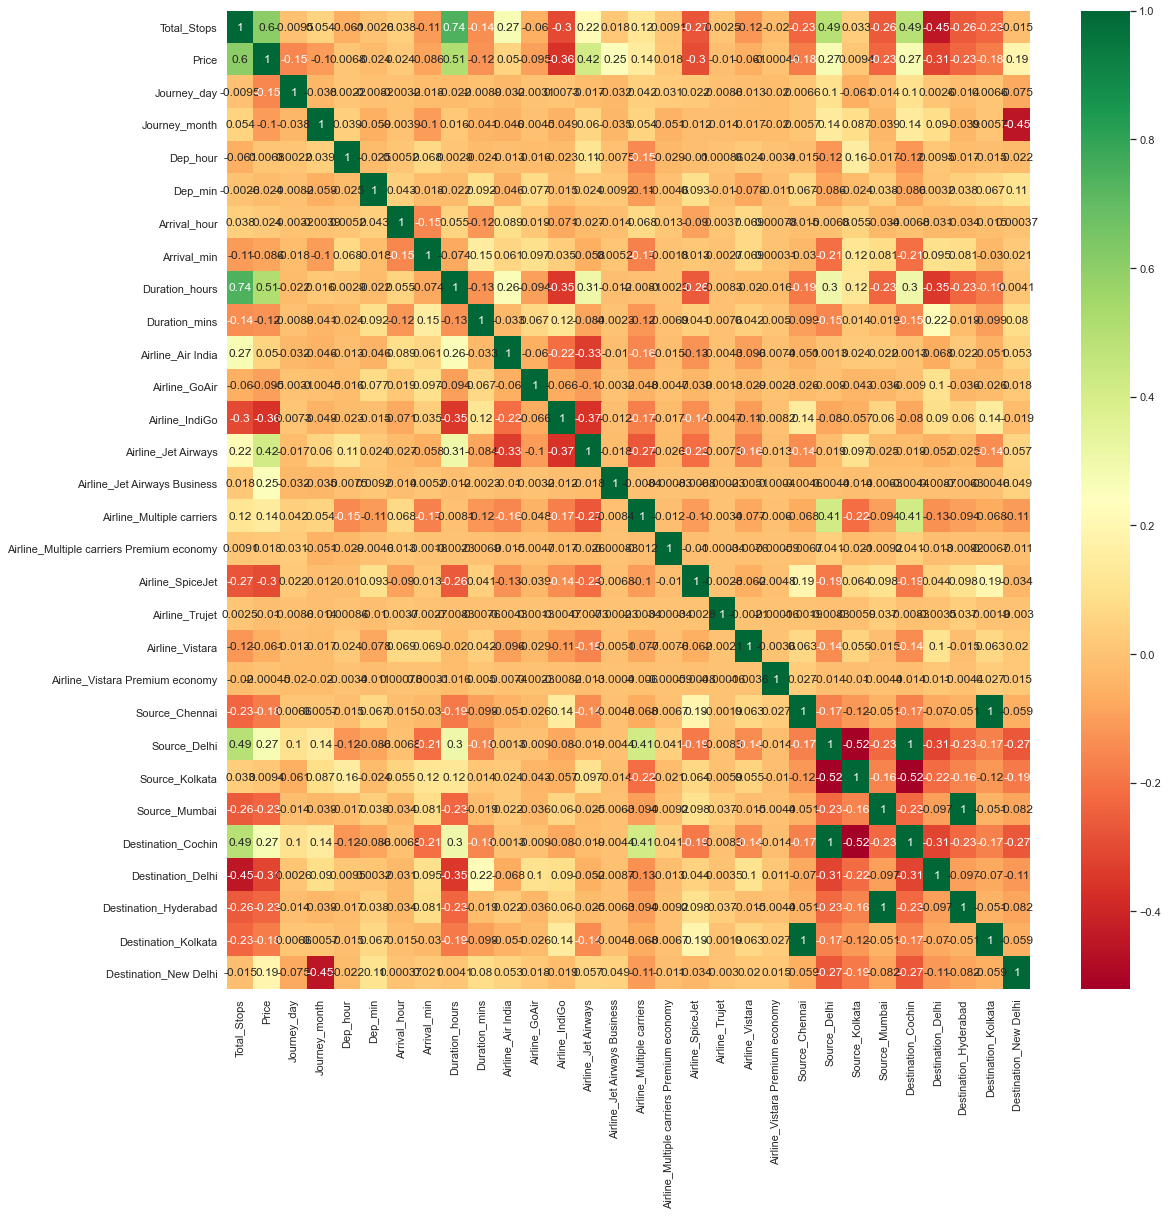

In [128]:
# Check for Feature Selection and Multicolleniarity

plt.figure(figsize = (18,18))
sns.heatmap(df.corr(), annot = True, cmap = "RdYlGn")
plt.show()

In [129]:
# Important feature using ExtraTreesRegressor

from sklearn.ensemble import ExtraTreesRegressor
selection = ExtraTreesRegressor()
selection.fit(X, y)

ExtraTreesRegressor()

In [130]:
print(selection.feature_importances_)

[2.33042116e-01 1.44505930e-01 5.30738885e-02 2.38322592e-02
 2.13513415e-02 2.74049767e-02 1.95797725e-02 1.09116425e-01
 1.79212683e-02 9.95279139e-03 1.92721091e-03 1.83837106e-02
 1.42063481e-01 6.73982381e-02 1.83149271e-02 8.57353804e-04
 2.78148856e-03 1.14854866e-04 5.07941205e-03 8.68322045e-05
 5.18353082e-04 1.23333486e-02 3.26564800e-03 6.30290640e-03
 1.09305466e-02 1.76726126e-02 6.65848217e-03 4.55471008e-04
 2.50743525e-02]


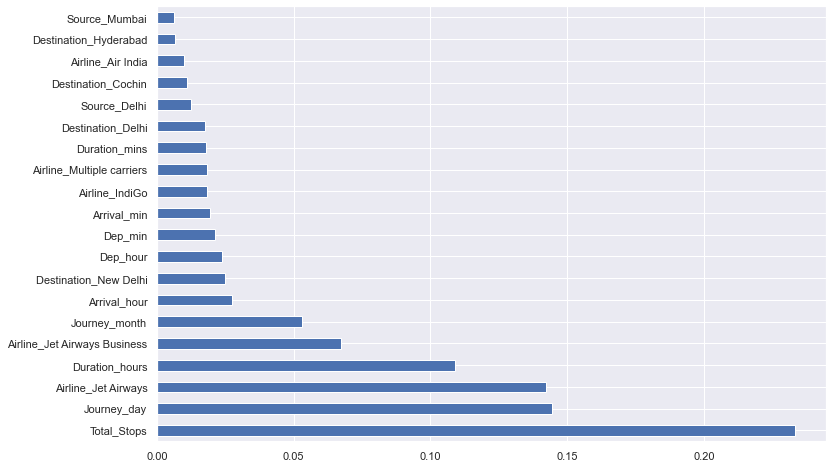

In [131]:
#plot graph of feature importances for better visualization

plt.figure(figsize = (12,8))
feat_importances = pd.Series(selection.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

**I will select all the features for my model**

### Fitting best model using GridSearchCV

In [132]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(6836, 29)
(1709, 29)
(2137, 29)


In [133]:
# Number of trees in random forest
n_estimators = [100,200,300]
max_features = ['auto', 'sqrt']
max_depth = [4,7,10]
min_samples_split = [5, 7, 9]

param = {'n_estimators': n_estimators,
         'max_depth': max_depth,
               }

print(param)


{'n_estimators': [100, 200, 300], 'max_depth': [4, 7, 10]}


In [134]:
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgbo
from sklearn.linear_model import LinearRegression

algos = {
        'XGBoostRegressor': {
            'model': xgbo.XGBRegressor(),
            'params': param
        },
        'LinearRegression': {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        }
    }

def find_best_model_using_gridsearchcv(X,y):
    
    scores = []
   
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=5, n_jobs=-1, verbose=2, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model_name' : algo_name,
            'model': config["model"],
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model_name', 'model','best_score','best_params'])

new_df = find_best_model_using_gridsearchcv(X_train ,y_train)
new_df

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   28.3s finished


Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


,model_name,model,best_score,best_params
0,XGBoostRegressor,"XGBRegressor(base_score=None, booster=None, co...",0.807916,"{'max_depth': 4, 'n_estimators': 200}"
1,LinearRegression,LinearRegression(),0.615004,{'normalize': False}


**Let's evalute the performance of each model in test set**

In [135]:
from sklearn.metrics import r2_score

accuracys = {}
for i in range(len(new_df)):
    row = new_df.iloc[i]
    model_name = row.loc["model_name"]
    best_params = row.loc["best_params"]
    model = row.loc["model"]
    model.set_params(**best_params)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    score = r2_score(y_test, pred)
    accuracys[model_name] = [score, model]

print(accuracys)

{'XGBoostRegressor': [0.8421368030571486, XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)], 'LinearRegression': [0.6192649989303397, LinearRegression()]}


In [136]:
[score, best_xgb] = accuracys.get("XGBoostRegressor")
best_xgb

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [137]:
print(r2_score(y_test, best_xgb.predict(X_test)))

0.8421368030571486


**As we see, the performance of XGBoost on test set is higher than the performance of Linear Regression. So we select XGBoost.**

In [138]:
import pickle

file = open('xgboost.pkl', 'wb')
pickle.dump(best_xgb, file)

In [139]:
model = xgb.XGBRegressor()
eval_set = [(X_train, y_train), (X_val, y_val)]
model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="rmse", eval_set=eval_set, verbose=True)

[0]	validation_0-rmse:7376.78760	validation_1-rmse:7383.88770
[1]	validation_0-rmse:5463.70996	validation_1-rmse:5512.53369
[2]	validation_0-rmse:4164.75488	validation_1-rmse:4282.79199
[3]	validation_0-rmse:3313.77686	validation_1-rmse:3462.20801
[4]	validation_0-rmse:2791.11645	validation_1-rmse:2990.56738
[5]	validation_0-rmse:2473.09595	validation_1-rmse:2713.39478
[6]	validation_0-rmse:2288.76978	validation_1-rmse:2553.13428
[7]	validation_0-rmse:2144.66260	validation_1-rmse:2445.64551
[8]	validation_0-rmse:2077.52148	validation_1-rmse:2376.89331
[9]	validation_0-rmse:1994.25647	validation_1-rmse:2323.62256
[10]	validation_0-rmse:1924.84680	validation_1-rmse:2275.64404
[11]	validation_0-rmse:1844.51660	validation_1-rmse:2219.92554
[12]	validation_0-rmse:1804.02820	validation_1-rmse:2184.42603
[13]	validation_0-rmse:1770.88245	validation_1-rmse:2164.24072
[14]	validation_0-rmse:1749.15601	validation_1-rmse:2170.50732
[15]	validation_0-rmse:1730.06067	validation_1-rmse:2154.36353
[1

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

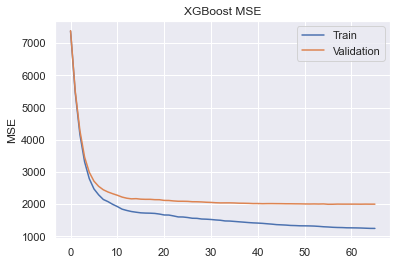

In [140]:
import matplotlib.pyplot as plt

results = model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Validation')
ax.legend()
plt.ylabel('MSE')
plt.title('XGBoost MSE')
plt.show()

In [141]:
pred = model.predict(X_test)
r2_score(y_test, pred)

0.8394439972431647

In [80]:
def find_best_model_using_cv(X,y, model):
    n_estimators = [100,200,300]
    max_features = ['auto', 'sqrt']
    max_depth = [4,7,10]
    min_samples_split = [5, 7, 9]

    param = {'n_estimators': n_estimators,
          'max_depth': max_depth,
          'max_features' : max_features,
          'min_samples_split': min_samples_split
        }
    
    dic = {}
    
    # scoring atribute can be specified, n_iter must be specified in case of RandomizedSearchCV
    gs =  GridSearchCV(model, param, cv=8, n_jobs=-1, verbose=5) 
    gs.fit(X,y)
    dic['best_params'] = gs.best_params_
    dic['best_score'] = gs.best_score_
    dic['best_estimator'] = gs.best_estimator_

    return dic 

dic = find_best_model_using_cv(X_train, y_train, model)
print(dic['best_params'])
print(dic['best_score'])

Fitting 8 folds for each of 54 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  3.8min finished


[12:53:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { max_features, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


{'max_depth': 4, 'max_features': 'auto', 'min_samples_split': 5, 'n_estimators': 100}
0.802082630860429


In [58]:
from sklearn.pipeline import Pipeline

In [59]:
param

{'n_estimators': [100, 200, 300], 'max_depth': [4, 7, 10]}

In [60]:
# Create a pipeline
pipe = Pipeline([("model", LinearRegression())])
# Create dictionary with candidate learning algorithms and their hyperparameters
grid_param = [
                {"model": [LinearRegression()],
                 "model__normalize": [True,False],
                 },

                {"model": [xgbo.XGBRegressor()],
                 "model__n_estimators": [100, 200, 300],
                 "model__max_depth" : [4,7,10]}]
# create a gridsearch of the pipeline, the fit the best model
gridsearch = GridSearchCV(pipe, grid_param, cv=5, 
                          verbose=5, n_jobs=-1) 

best_model = gridsearch.fit(X_train,y_train)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:  1.0min finished


In [61]:
print(best_model.best_estimator_)
print("The accuracy of the model is:", r2_score(y_test, best_model.predict(X_test)))

Pipeline(steps=[('model',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=4, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=300,
                              n_jobs=4, num_parallel_tree=1, random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=1, tree_method='exact',
                              validate_parameters=1, verbosity=None))])
The accuracy of the model is: 0.8526929881754246


In [52]:
from sklearn.cluster import KMeans
from kneed import KneeLocator

In [60]:
model_directory = 'models/'

def save_model(model, filename):
    try:
        path = os.path.join(model_directory,filename) #create seperate directory for each cluster
        if os.path.isdir(path): #remove previously existing models for each clusters
            shutil.rmtree(model_directory)
            os.makedirs(path)
        else:
            os.makedirs(path) 
        
        with open(path +'/' + filename+'.sav', 'wb') as f:
            pickle.dump(model, f) # save the model to file

        return 'success'
    
    except Exception as e:
        raise Exception()

3


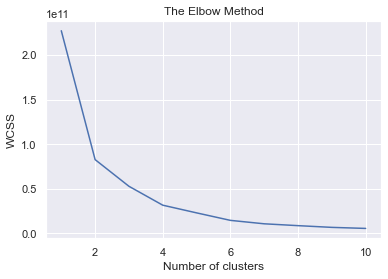

In [75]:
### Clustering and creating one model for each cluster

new_X = X.copy()
def elbow_plot(X):
    
    wcss=[] # initializing an empty list
    try:
        for i in range (1,11):
            kmeans=KMeans(n_clusters=i,init='k-means++',random_state=42) # initializing the KMeans object
            kmeans.fit(X) # fitting the data to the KMeans Algorithm
            wcss.append(kmeans.inertia_)

        plt.plot(range(1,11),wcss) # creating the graph between WCSS and the number of clusters
        plt.title('The Elbow Method')
        plt.xlabel('Number of clusters')
        plt.ylabel('WCSS')
        plt.savefig('K-Means_Elbow.PNG') # saving the elbow plot locally

        kn = KneeLocator(range(1, 11), wcss, curve='convex', direction='decreasing')
        nr_clusters = kn.knee
        print(nr_clusters)
        return nr_clusters
    except Exception as e:
        print("Exception Elbow Plot")
        raise e
        
        
n_clusters = elbow_plot(new_X)
n_clusters = 2

In [76]:
# Creating the clusters 

def create_clusters(X_data, nr_clusters):
    kmeans = KMeans(n_clusters = nr_clusters, init='k-means++', random_state=42)
    y_kmeans=kmeans.fit_predict(X_data)
    X_data['Cluster'] = y_kmeans
    X_data['Label'] = y
    
    message = save_model(kmeans, 'KMeans')
    return X_data


new_X = create_clusters(X, n_clusters)

In [77]:
# With 3 and 4 Clusters we have clusters with few training examples we must decrease the nr of clusters

new_X['Cluster'].value_counts()

1    6057
0    4625
Name: Cluster, dtype: int64

In [90]:
def get_best_params_for_xgboost(x_train, y_train):
    try:
        # initializing with different combination of parameters
        param_grid = {
                'learning_rate': [0.5, 0.1, 0.01, 0.001],
                'max_depth': [3, 5, 10, 20],
                'n_estimators': [10, 50, 100, 200]

            }
        
        # Creating an object of the Grid Search class
        grid= GridSearchCV(xgb.XGBRegressor(), param_grid, cv=10, verbose=3, n_jobs=-1)
        # finding the best parameters
        grid.fit(x_train, y_train)

        # creating a new model with the best parameters
        model = xgb.XGBRegressor(learning_rate = grid.best_params_['learning_rate'] ,
                             max_depth = grid.best_params_['max_depth'], 
                             n_estimators = grid.best_params_['n_estimators'])
        # training the mew model
        model.fit(x_train, y_train)
        return model
    
    except Exception as e:
        print('Exception in XGBoost')
        raise Exception

In [91]:
def get_best_params_for_random_forest(x_train, y_train):
    try:
        # initializing with different combination of parameters
        param_grid = {"n_estimators": [10, 50, 100, 130],
                      "max_depth": range(2, 4, 1)}
        
        # Creating an object of the Grid Search class
        grid= GridSearchCV(RandomForestRegressor(), param_grid, cv=10, verbose=3, n_jobs=-1)
        # finding the best parameters
        grid.fit(x_train, y_train)

        # creating a new model with the best parameters
        model = RandomForestRegressor(max_depth = grid.best_params_['max_depth'], 
                                      n_estimators = grid.best_params_['n_estimators'])
        # training the mew model
        model.fit(x_train, y_train)
        return model
    
    except Exception as e:
        print('Exception in Random Forest')
        raise Exception

In [92]:
def get_best_model(x_train, y_train, x_test, y_test):
    try:
        # create best model for xgboost
        xgboost = get_best_params_for_xgboost(x_train, y_train)
        prediction_xgboost = xgboost.predict(x_test) # Predictions using the XGBoost Model
        
        # Regression (we can also use adj r squared r2_score function)
        xgboost_score = r2_score(y_test, prediction_xgboost)
        print('XGBoost Accuracy : ' + str(xgboost_score))
    
        # Classification
#         if len(y_test.unique()) == 1: #if there is only one label in y, then roc_auc_score returns error. We will use accuracy in that case
#             xgboost_score = accuracy_score(y_test, prediction_xgboost)
#         else:
#             xgboost_score = roc_auc_score(y_test, prediction_xgboost) # AUC for XGBoost

        # create best model for Random Forest
        random_forest = get_best_params_for_random_forest(x_train, y_train)
        prediction_random_forest = random_forest.predict(x_test) # prediction using the Random Forest Algorithm

        # Regression
        random_forest_score = r2_score(y_test, prediction_random_forest) 
        print('Random Forest Accuracy : ' + str(random_forest_score))
        
        # Classification
#         if len(y_test.unique()) == 1:#if there is only one label in y, then roc_auc_score returns error. We will use accuracy in that case
#             random_forest_score = accuracy_score(y_test, prediction_random_forest)
#         else:
#             self.random_forest_score = roc_auc_score(y_test, prediction_random_forest) # AUC for Random Forest
                

        # Comparing the models and selecting the best model
        if random_forest_score < xgboost_score:
            return 'XGBoost', xgboost
        else:
            return 'RandomForest', random_forest
        
    except Exception as e:
        print("Exception in get_best_model")
        raise Exception

In [93]:
list_of_clusters = new_X['Cluster'].unique()

for i in list_of_clusters:
    cluster_data= new_X[new_X['Cluster']==i] # filter the data for one cluster
    cluster_features=cluster_data.drop(['Label'],axis=1)
    cluster_label= cluster_data['Label']

    x_train, x_test, y_train, y_test = train_test_split(cluster_features, cluster_label, test_size=0.2, random_state=1)
    
    print('Cluster ' + str(i) + " :  ")
    
    best_model_name, best_model = get_best_model(x_train,y_train,x_test,y_test)
    message = save_model(best_model, best_model_name+str(i))
    

Cluster 1 :  
Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:   52.8s
[Parallel(n_jobs=-1)]: Done 324 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 548 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:  3.3min finished


XGBoost Accuracy : 0.8445532142339618
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    7.8s finished


Random Forest Accuracy : 0.6301917596629101
Cluster 0 :  
Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   48.1s
[Parallel(n_jobs=-1)]: Done 336 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:  2.6min finished


XGBoost Accuracy : 0.7083237979560891
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    5.2s finished


Random Forest Accuracy : 0.4643457866623022


**Random Forest gives low accuracy since we have few datas in clusters (around 5k). It would be better to go with Decision Tree**